## From Principal Component (PCA) to Direct Coupling Analysis (DCA) of Coevolution in Proteins

This notebook takes a look at a 2013 paper from Simona Cocco, Remi Monasson, Martin Weigt titled
**From Principal Component to Direct Coupling Analysis of Coevolution in Proteins: Low-Eigenvalue Modes are Needed for Structure Prediction.** *\[2013Cocco\]*

Link: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003176

This paper looks at extracting functional and structural information from Multiple Sequence Alignments (MSA) of homologous proteins. First a covariance matrix of the residues are created from the MSA. Then the paper connects two approaches 

*  PCA - which identifies correlated groups of residues
*  DCA - which identifies residue-residue contacts

It shows how these two methods are related in non-intuitive ways using sophisticated statistical-physics models. This connection between the two approaches allows one to perform some sort of "dimension reduction" on DCA and to accurately predict residue-residue contacts with a smaller number of parameters. It also shows that the low eigenvalue values, which are discarded by PCA, are actually important to recover contact information. 

### Sections

1. [Multiple Sequence Alignment](#msa)
2. [Re-weighting Sequences](#reweight)
3. [Compute Single and Double Site marginals](#marginals)
4. [Compute the Covariance matrix](#covmat)
5. [Maximum Entropy Modeling and Direct Coupling Analysis](#maxent)  
6. [Approximations to DCA](#approxdca)
7. [PSICOV - Sparse inverse covariance estimation](#2011PSICOV)
8. [Correlation Matrix and connection to PCA](#pcaconnect)
9. [Results](#2013CoccoResults)
    - [Hopfield Potts model](#HopfieldPotts)
    - [Dimension Reduction in the space of patterns](#patterndimreduction)
    - [Contact Prediction](#contactprediction)
***


### Multiple Sequence Alignment (MSA)  <a id="msa"></a>

We use a [DHFR](https://www.uniprot.org/uniprot/P00374) alignment as an example to try out the methods of the papers. The alignment file is generated by [jackhmmer](https://www.ebi.ac.uk/Tools/hmmer/search/jackhmmer)


```
sp|P00374|DYR_HUMAN Dihydrofolate reductase OS=Homo sapiens OX=9606 GN=DHFR PE=1 SV=2
MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEGKQNLVIMGKKTWFS
IPEKNRPLKGRINLVLSRELKEPPQGAHFLSRSLDDALKLTEQPELANKVDMVWIVGGSS
VYKEAMNHPGHLKLFVTRIMQDFESDTFFPEIDLEKYKLLPEYPGVLSDVQEEKGIKYKF
EVYEKND
```

Note: Not exactly sure how the alignment is generated. 

```shell
jackhmmer -A DHFR_uniref90.aln --noali --notextw P00374.fasta uniref90.fasta
# some filtering script
```

In [1]:
import os
import itertools
import numpy as np
import scipy
import scipy.linalg

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
datadir = "../data"
msa_file = os.path.join(datadir, "DHFR.aln")

# Read all the lines in the file into a 2D array of type S1
with open(msa_file) as fh:
    arr = np.array([[x for x in line.strip()] for line in fh], np.dtype("S1"))

print("shape =", arr.shape, ",dtype= ", arr.dtype)

shape = (56165, 186) ,dtype=  |S1


In [3]:
# M is the number of sequences
# L is the length
M, L = arr.shape
print("Number of sequences : {} ".format(M))
print("Sequence Length : {}".format(L))

Number of sequences : 56165 
Sequence Length : 186


In [4]:
# the first sequence
arr[0, :].tostring()

b'VRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFKYFQRMTTTSSVEGKQNLVIMGRKTWFSIPEKNRPLKDRINIVLSRELKEPPRGAHFLAKSLDDALRLIEQPELASKVDMVWIVGGSSVYQEAMNQPGHLRLFVTRIMQEFESDTFFPEIDLGKYKLLPEYPGVLSEVQEEKGIKYKFEVYEKKD'

In [5]:
# the second sequence
arr[1, :].tostring()

b'----SIVVVMCKRFGIGRNGVLPWSPLQADMQRFRSITAG-------GGVIMGRTTFDSIPEEHRPLQGRLNVVLTTSADLMKNSNIIFVSSFDELDAIVGL----HDHLPWHVIGGVSVYQHFLEKSQVTSMYVTFVDGSLECDTFFPHQFLSHFEITRA---SALMSDTTSGMSYRFVDYTR--'

We can order the amino acids any way we like. Here is a sorting based on some amino acid properties. 
https://proteinstructures.com/Structure/Structure/amino-acids.html

In [6]:
AMINO_ACIDS = np.array([aa for aa in "RKDEQNHSTCYWAILMFVPG-"], "S1")

### Compute the weights of each sequence <a id="reweight"></a>

To compute the weight of a sequence, we first compute the hamming distance between this sequence and all the other sequences in the alignment. Then we count the number of these distances that are less than a cutoff. 

This count is 1 for isolated sequences. It is large for sequences that have many similar sequences in the alignment. The weight is reciprocal of the count. So it is 1 for isolated sequences and close to zero for sequences that have many similar sequences in the MSA. (Eqn 27 in 2013Cocco)

$$w_m = \frac{1}{ \| \{ n | 1 \leq n \leq M  ; d_H [ (a_1^n, \ldots, a_L^n), (a_1^m, \ldots, a_L^m) ] \leq xL \} \| }$$



In [7]:
hamming_cutoff = 0.2 # This is x in the equation above
def compute_weight(index, x=hamming_cutoff, arr=arr):
    hamming_distances = np.sum(arr[index, :] != arr, axis=1)
    count = np.sum(hamming_distances <= x * arr.shape[1]) # L = arr.shape[1]
    return (1.0 / count)

# compute the weight of the first sequence
compute_weight(0)

0.005681818181818182

In [8]:
progress_bar = True
try:
    from IPython.display import clear_output
except ImportError:
     progress_bar = False

weights_file = os.path.join(datadir, "DHFR.weights.npy")

if os.path.isfile(weights_file):
    weights = np.load(weights_file)
    print("Loading weights from : ", weights_file)

else:
    weights = np.zeros(M, dtype=np.float64)

    for i in range(M):
        weights[i] = compute_weight(i)
        if i % 100 == 0:
            if progress_bar:
                clear_output(wait=True)
            print ("Processing sequence", i, "of", M)
    np.save(weights_file, weights)
    print("Finished computing sequence weights and saved to : ", weights_file)


Loading weights from :  ../data/DHFR.weights.npy


In [9]:
# number of effective sequences
M_eff = sum(weights) # Eqn 28 in 2013Cocco
print(int(round(M_eff)))

15238


In [10]:
# q is the alphabet
q = len(AMINO_ACIDS)
pseudo_count = round(M_eff)

### Compute Weighted Single and Double site marginals <a id="marginals"></a>

We first compute the weighted counts for the single site marginals $$\sum_{m=1}^M w_m \delta_{a, a_i^m},$$ and then we compute the weighted counts for the double site marginals $$\sum_{m=1}^M w_m \delta_{a, a_i^m} \delta_{b, a_j^m}.$$ The second computation takes a long time since the arrays are too large to compute outer products and broadcast them. 

To get the actual marignals we need to divide these weighted counts above by the sum of the weights. However, we only do this after adding a pseudocount to regularize the resulting covariance matrix. (Eqns 29 and 30 in 2013Cocco.)


In [11]:
single_site_marginal_file = os.path.join(datadir, "DHFR.single.npy")
double_site_marginal_file = os.path.join(datadir, "DHFR.double.npy")

if os.path.isfile(double_site_marginal_file) and os.path.isfile(single_site_marginal_file):
    f_i_a = np.load(single_site_marginal_file)
    print("Loading single site marginals from ", single_site_marginal_file)

    f_i_j_a_b = np.load(double_site_marginal_file)
    print("Loading double site marginals from ", double_site_marginal_file)    

else:
    # We first compute a one-hot matrix of shape (M, L, q)
    # which is 0/1 in index (m, i, a) depending on whether 
    # Protein *m* has amino acid *a* in position *i* 
    arr_onehot = np.zeros(arr.shape + (q,), dtype=np.uint8)
    for i, a in enumerate(AMINO_ACIDS):
        arr_onehot[..., i] = (arr == a)
    print("arr_onehot.shape = {}".format(arr_onehot.shape))
    
    # we reorder the one-hot axes so that the sequences are in the last dimension
    # this allows us to multiply easily by the weights using broadcasting
    arr_onehot_reorder = np.moveaxis(arr_onehot, 0, 2)
    weighted_arr_onehot = arr_onehot_reorder * weights

    
    # Set up the weighted double site marginals array
    f_i_j_a_b = np.zeros((L, q, L, q), dtype=weights.dtype)
    
    # we cannot use outer products here because our arrays are too big
    # So we iterate
    for j, b in itertools.product(range(L), range(q)):
        f_i_j_a_b[:, :, j, b] = np.sum((weighted_arr_onehot * arr_onehot_reorder[j, b, :]), axis=-1)
        if progress_bar:
            clear_output(wait=True)
        print("Finished processing j={}, b={}, AA={}".format(j, b, AMINO_ACIDS[b].tostring().decode()))

    # Weighted Single Site Marignals
    f_i_a = np.sum((arr_onehot_reorder * weights), axis=-1)
    print("f_i_a.shape = {}".format(f_i_a.shape)) 

    
    np.save(single_site_marginal_file, f_i_a)
    np.save(double_site_marginal_file, f_i_j_a_b)
    
    # delete large temporary arrays
    del weighted_arr_onehot, arr_onehot_reorder, arr_onehot
    print("Finished computing single and double site marginals and saved to cache files")

Loading single site marginals from  ../data/DHFR.single.npy
Loading double site marginals from  ../data/DHFR.double.npy


In [12]:
# Add Pseudo count and compute the marginals (Eqn 29 and 30 2013Cocco)
pseudo_count_ratio = float(pseudo_count) / (M_eff + pseudo_count)
f_i_a = (pseudo_count_ratio / q ) + (1 - pseudo_count_ratio) * f_i_a / M_eff
f_i_j_a_b = (pseudo_count_ratio  / (q*q) ) + (1 - pseudo_count_ratio) * f_i_j_a_b / M_eff


# The formula for f_i_j_a_b is a little different when i==j
# essentially we have f_i_a on the diagonal and zero's everywhere else. 
for i in range(L):
    f_i_j_a_b[i, :, i, :] = np.diag(f_i_a[i, :])

### Compute the covariance matrix <a id="covmat"></a>



In [13]:
# Covariance Matrix
# We take an outer product of f_i_a with itself using numpy's broadcasting rules. 
# This gives us a matrix where the (i,a, j, b) index is f[i,a] * f[j,b]
C_i_j_a_b = f_i_j_a_b  - f_i_a[:, :, np.newaxis, np.newaxis] * f_i_a[np.newaxis, np.newaxis, :, :] 

# we project the covariance matrix down the first q-1 elements
# Since the frequencies add up to 1 we can discard amino-acid value (a = q) for each site
# without losing any information
C_i_j_a_b = C_i_j_a_b[:, :(q-1), :, :(q-1)]
print("C_i_j_a_b.shape = {}".format(C_i_j_a_b.shape)) 

# delete the frequency matrices now that we have a covariance matrix.
del f_i_a, f_i_j_a_b

C_i_j_a_b.shape = (186, 20, 186, 20)


### Maximum Entropy Modeling and Direct Coupling Analysis<a id="maxent"></a>

It is hard to infer contact information from this covariance matrix as a non-zero covariance between two sites does not imply that they directly interact or are in contact. If we have site $i$ interacting  with $j$ and site $j$ interacting with $k$, then $i$ and $k$ will show correlations even though they do not directly interact. 

So we decide to look for a (protein family specific) probability model $\bf P$ on the level of sequences that satisfies three conditions. 
1. The single site marginals of $\bf P$ are equal to $f_i(a)$.   
In other words, the sum of probabilities of all proteins with a in the $i$-th position is equal to the value of $f_i(a)$.
2. The double site marginals of $\bf P$ are equal to $f_{ij}(a,b)$.  
In other words, the sum of probabilities of all proteins with $a$ in the $i$-th position and $b$ in the $j$-th position is equal to $f_{ij}(a,b)$.
3. $\bf P$ has the **maximum possible entropy** so we maximize
$$ H[{\bf P}] = - \sum_{\text{all sequences of length L}} P \log P$$

Condition 1 gives us $Lq$ constraints and Condition 2 gives us $\frac{L(L-1)}{2} q^2$ additional constraints. This allows us to do a gigantic constrained optimization using Lagrange Multipliers and come up with an analytic form for $\bf P$.
$$ P(a_1, \ldots, a_L) = \frac{1}{Z} \exp{ \bigg\{ \frac{1}{2} \sum_{i,j} e_{ij}(a_i, a_j) + \sum_{i} h_i(a_i) \bigg\} }$$

Here $Z$ is a normalization constant that makes sure that all the probabilities add up to $1$. The parameters $e_{ij}(a,b)$ are the direct couplings and $h_i(a)$ are the local fields acting on single sites. These values have to be determined so that Conditions 1 and 2 are satisfied. 

It is not possible to compute these parameters exactly for reasonably sized proteins as calculating $Z$ and the marginals require summations over all $q^L$ possible amino-acid sequences. 


We can also view the Maximum Entropy model via its dual Maximum Likelihood problem. i.e. Assume that $P$ has the form above and maximize $$\mathcal{L} \big[ \{e_{ij}(a,b), h_i(a) \} \big\lvert \text{MSA} \big] = \frac{1}{M} \sum_{m=1}^{M} \log P(a_1^M, \ldots, a_L^m)$$ 



### Approximations to DCA <a id="dcaapprox"></a>
There are [several approximations](https://en.wikipedia.org/wiki/Direct_coupling_analysis) to estimate the parameters above

* Boltzmann Machine Learning (BM)
* Message passing / belief propagation (mpDCA)
* Mean Field Approximation (mfDCA)
* Gaussian Approximation (gaussDCA)
* Pseudolikelihoods Maximization (PLM)
* Adaptive Cluster Expansion (ACE)

### Mean Field Approximation <a id="meanfield"></a>
This is an approximation in statistical physics to help solve this intractable problem. We expand the exponential of the sum of the direct couplings using a Taylor Series expansion and then only keep the linear terms. With this approximation the values for the direct couplings are $$e_{ij}(a,b) = (C^{-1})_{ij}(a,b) \qquad \forall i,j, \enspace \forall a,b=1, \ldots, q-1$$ and $$e_{ij}(a,q) = e_{ij}(q,a) = 0 \qquad \forall a = 1, \ldots, q,$$ and $$ h_i(q) = 0.$$

This approximation approach is known as **mean field direct coupling analysis (mfDCA)**. Once the direct couplings have been calculated, they can be used to predict contacts between residues. This post processing prediction step will be covered later. 

In [14]:
# Our Covariance matrix is now invertible
cov = C_i_j_a_b.reshape((L*(q-1), L*(q-1)))
eigvals = np.linalg.eigvalsh(cov)

print("Number of eigenvalues: {}".format(eigvals.size))
print("Number of eigenvalues non-positive: {}".format(np.sum(eigvals <= 0)))

Number of eigenvalues: 3720
Number of eigenvalues non-positive: 0


### Contact Prediction <a id="contactprediction" />

In [15]:
# load in the contacts file
contacts_5A = np.array(np.load("{0:}/5A-HA-3k47_contacts.pkl".format(datadir)))
contacts_8A = np.array(np.load("{0:}/8A-HA-3k47_contacts.pkl".format(datadir))) 

# convert contacts to 0 based indices
contacts_5A -= 1
contacts_8A -= 1

# create a contacts array
contacts = np.zeros((L, L), dtype=np.int)
contacts[contacts_8A[:, 0], contacts_8A[:, 1]] = 8
contacts[contacts_8A[:, 1], contacts_8A[:, 0]] = 8
contacts[contacts_5A[:, 0], contacts_5A[:, 1]] = 5
contacts[contacts_5A[:, 1], contacts_5A[:, 0]] = 5

In [16]:
# Getting the full couplings via the full inverse covariance matrix
invCov = np.linalg.inv(cov)
e_i_j_a_b = invCov.reshape((L, q-1, L, q-1))

To measure coupling strength we map each of the $q\times q$ coupling matrices $e_{ij}(a,b)$ on to a scalar parameter for each pair of indices in the sequence. $1 \leq i < j \leq L.$ 

First we linearly transform the coupling matrices $$\tilde{e}_{ij}(a,b) = e_{ij}(a,b) - e_{ij}(\cdot, b) - e_{ij}(a, \cdot) + e_{ij}( \cdot , \cdot), $$ where the '$\cdot$' denotes the average over all the amino acids in that position. Then we take the Frobenuis norm of this linearly transformed matrix at each pair of sites $$F_{ij} = \sqrt{\sum_{a,b=1}^{q} \tilde{e}_{ij}(a,b)}.$$

This norm is then adjusted by an *average product correction* term (APC) to account for phylogenetic bias and insufficient sampling. $$F_{ij}^{APC} = F_{ij} - \frac{F_{\cdot j} F_{i \cdot}}{F_{\cdot \cdot}},$$ where the '$\cdot$' now represents a position average. 

In [17]:
etilde_i_j_a_b = e_i_j_a_b - e_i_j_a_b.mean(axis=3, keepdims=True) - \
        e_i_j_a_b.mean(axis=1, keepdims=True) + \
        e_i_j_a_b.mean(axis=3, keepdims=True).mean(axis=1, keepdims=True)

etilde_i_j_a_b.shape

F_i_j = np.linalg.norm(etilde_i_j_a_b, ord="fro", axis=(1,3))

Fapc_i_j = F_i_j - F_i_j.mean(axis=0, keepdims=True) * F_i_j.mean(axis=1, keepdims=True) \
    / F_i_j.mean(axis=0, keepdims=True).mean(axis=1, keepdims=True)

Fapc_i_j_upper = np.triu(Fapc_i_j, k=1)

In [43]:
# Now we look at Fapc and pick out the largest and most interesting contacts
index_i, index_j = np.unravel_index(Fapc_i_j_upper.flatten().argsort(), Fapc_i_j_upper.shape)
ij_dist = np.abs(index_j - index_i)
interesting_contacts = np.where(ij_dist >=5)[0]

n = 100
topn_i, topn_j = index_i[interesting_contacts[-n:]], index_j[interesting_contacts[-n:]]

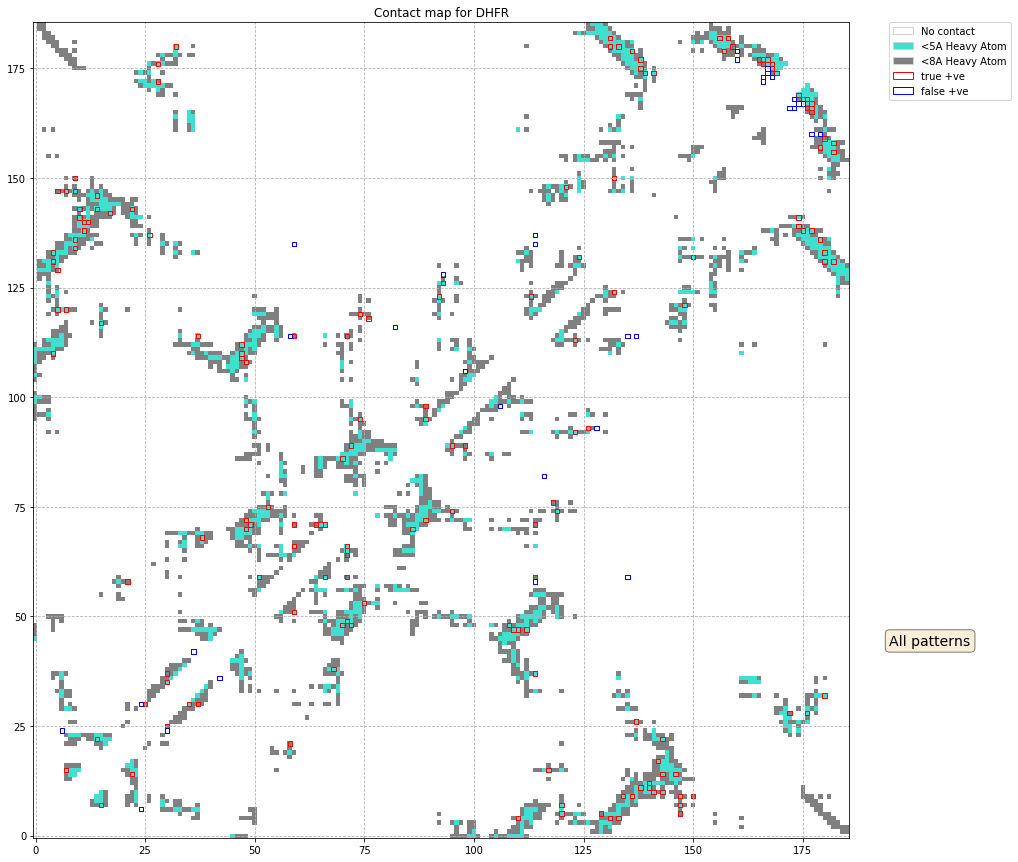

In [44]:
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# little rectanges for the true and false positives
matched_rects = []
unmatched_rects = []
for i, j in zip(topn_i, topn_j):
    if contacts[i, j]:
        rects = matched_rects
    else:
        rects = unmatched_rects
    rects.append(mpatches.Rectangle((i - 0.5, j - 0.5), 1, 1))
    rects.append(mpatches.Rectangle((j - 0.5, i - 0.5), 1, 1))

    
fig, ax = plt.subplots(figsize=(15,15))
plt.title("Contact map for DHFR")

cmap_labels = ["No contact", "<5A Heavy Atom", "<8A Heavy Atom"]
cmap = colors.ListedColormap(['white', 'turquoise', 'grey'])
bounds = [0,0.01,5.01,10]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(contacts, cmap=cmap, norm=norm, origin="lower")

pc_matched = PatchCollection(matched_rects, edgecolors='red', facecolors='none', transOffset=ax.transData)
pc_unmatched = PatchCollection(unmatched_rects, edgecolors='blue', facecolors='none', transOffset=ax.transData)
ax.add_collection(pc_matched)
ax.add_collection(pc_unmatched)

plt.grid(linestyle='--')

patches = [mpatches.Patch(facecolor=cmap.colors[i], label=l, edgecolor='lightgrey') 
           for i, l in enumerate(cmap_labels) ]
patches.append(mpatches.Patch(label='true +ve', edgecolor='red', facecolor='none'))
patches.append(mpatches.Patch(label='false +ve', edgecolor='blue', facecolor='none'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

textstr = "All patterns"
_ = ax.text(1.05, 0.25, textstr, transform = ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


In [45]:
# Numpy doesn't have a ufunc for addition of byte-strings (type "|S1" is deprecated anyway)
import operator
vadd = np.vectorize(operator.add)

In [46]:
np.random.seed(1)
rand_idx = np.random.choice(arr.shape[0], size=5000, p=weights / M_eff)

arr_rand = arr[rand_idx,]

count_unique_pairs_rand = np.zeros((L,L), dtype=np.float)

In [47]:
count_unique_pairs_rand_file = os.path.join(datadir, "DHFR.count.unique.pairs.random.npy")
if os.path.isfile(count_unique_pairs_rand_file):
    count_unique_pairs_rand = np.load(count_unique_pairs_rand_file)
    print("Loading count of unique random pairs from :", count_unique_pairs_rand_file)
else:
    for i in range(L):
        for j in range(L):
            if (j < i):
                continue
            concat_arr = vadd(arr_rand[:, i], arr_rand[:, j])
            count_unique_pairs_rand[i,j] = np.unique(concat_arr).size
    count_unique_pairs_rand_file = os.path.join(datadir, "DHFR.count.unique.pairs.random.npy")
    np.save(count_unique_pairs_rand_file, count_unique_pairs_rand)
    print("Finished saving Random Unique Counts file")

Loading count of unique random pairs from : ../data/DHFR.count.unique.pairs.random.npy


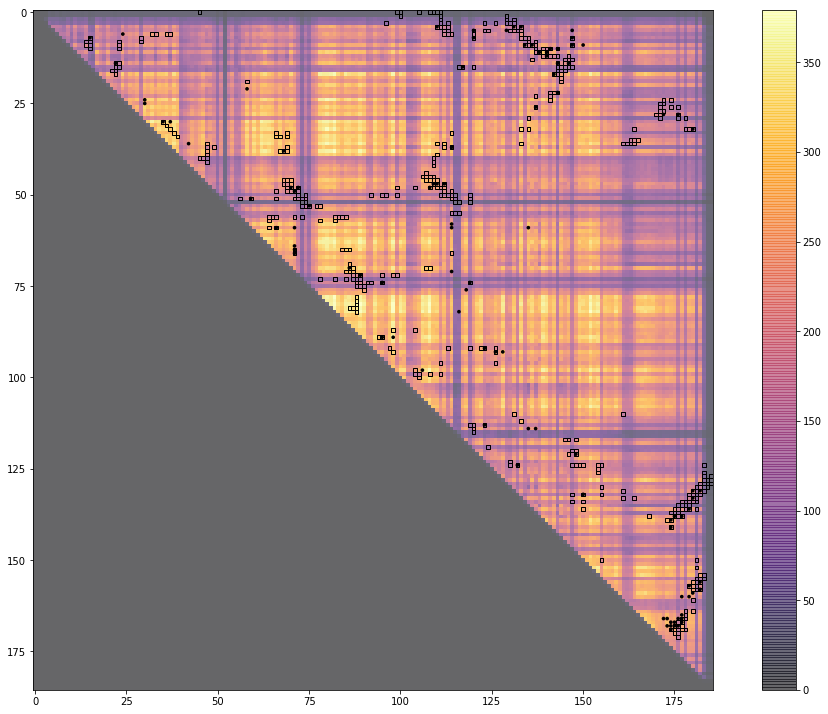

In [132]:
fig, ax = plt.subplots(figsize=(7*2.5, 5*2.5))

im = ax.imshow(count_unique_pairs_rand, cmap="inferno", alpha=0.6)
#ax.grid(color="black", linewidth=1, linestyle="--", alpha=0.8)

contact_rects = [mpatches.Rectangle((i-0.5, j-0.5), 1, 1) for i, j in zip(*np.where(contacts == 5)) if i > j]
pc_contacts = PatchCollection(contact_rects, edgecolors='black', facecolors='none', 
                              transOffset=ax.transData)
ax.add_collection(pc_contacts)
predicted_rects = [mpatches.Circle((i, j), 0.5) for j, i in zip(topn_i, topn_j)]
pc_predicted = PatchCollection(predicted_rects, edgecolors="none", facecolors='black', 
                               transOffset=ax.transData)
ax.add_collection(pc_predicted)
fig.colorbar(im)

In [50]:
import pandas as pd

In [147]:
# create upper triangular indices
i, j = zip(*((i, j) for i in range(L) for j in range(L) if i < j))
# create a dataframe of values at each of the upper triangular indices
df = pd.DataFrame({"i":i, "j":j, "unique_count":count_unique_pairs_rand[i, j], 
              "contacts":contacts[i, j]})
df["contacts"] = pd.Categorical(df["contacts"])
df["predicted"] = pd.Categorical(df["predicted"])

In [167]:
# add predictions
df["predicted"] = 0
for i, j in zip(topn_i, topn_j):
    df.loc[(df["i"] == i) & (df["j"] == j), "predicted"] = 1

In [169]:
pd.crosstab(df.contacts, df.predicted, margins=True)

predicted,0,1,All
contacts,,,
0,15714,17,15731
5,389,66,455
8,1002,17,1019
All,17105,100,17205


In [170]:
pd.crosstab(df.contacts, df.predicted,  values=df.unique_count, aggfunc=np.median, margins=True)

predicted,0,1,All
contacts,,,
0,194.0,248.0,194.0
5,163.0,217.5,168.0
8,183.0,234.0,184.0
All,193.0,228.0,193.0
